In [1]:
file_path_cif_1 = 'real_inputs/5MRC_body_aligned_2.cif'
file_path_cif_2 = 'real_inputs/5MRE_body_aligned.cif'

output_file_path_1 = file_path_cif_1.split(".cif")[0] + "_with_cols.cif"
output_file_path_2 = file_path_cif_2.split(".cif")[0] + "_with_cols.cif"

# Fix columns for gemmi reading
def reformat_file(file_path, out_file):
    with open(file_path, 'r') as input_file, open(out_file, 'w') as output_file:
        ready_for_atoms = False
        for line in input_file:
            if line.startswith('ATOM') or line.startswith('HETATM'):
                output_file.write(line.rsplit(maxsplit = 2)[0] + ' ' + line.split()[8].ljust(4) + ' ' + 
                                  line.split()[5].ljust(3) + ' ' + line.split()[16].ljust(2) + ' ' + 
                                  line.split()[3].ljust(4) + ' ' + line.split()[17].ljust(2) + '\n')
                ready_for_atoms = False
            elif not ready_for_atoms:
                if line.startswith('_atom_site.pdbx_formal_charge'):
                    ready_for_atoms = True
                    output_file.write("_atom_site.pdbx_formal_charge \n_atom_site.auth_seq_id \n_atom_site.auth_comp_id \n_atom_site.auth_asym_id \n_atom_site.auth_atom_id \n_atom_site.pdbx_PDB_model_num \n")
                else:
                    output_file.write(line)
                    
reformat_file(file_path_cif_1, output_file_path_1)
reformat_file(file_path_cif_2, output_file_path_2)

In [2]:
import gemmi
import pandas as pd
import inspect
import numpy as np

structure = gemmi.read_structure(output_file_path_1)
structure2 = gemmi.read_structure(output_file_path_2)

# Read in structures to dataframes
def read_in_structure(structure):
    atom_names = []
    residue_names = []
    chain_ids = []
    residue_numbers = []
    x_coords = []
    y_coords = []
    z_coords = []

    for chain in structure[0]:
        for residue in chain:
            for atom in residue:
                atom_names.append(atom.name)
                residue_names.append(residue.name)             
                chain_ids.append(chain.name)
                residue_numbers.append(residue.seqid.num)
                x_coords.append(atom.pos.x)
                y_coords.append(atom.pos.y)
                z_coords.append(atom.pos.z)

    data = {
        'AtomName': atom_names,
        'ResidueName': residue_names,
        'ChainID': chain_ids,
        'ResidueNumber': residue_numbers,
        'X': x_coords,
        'Y': y_coords,
        'Z': z_coords
    }

    df = pd.DataFrame(data)
    return df

df = read_in_structure(structure)
df2 = read_in_structure(structure2)

df['structure'] = '5MRC'
df2['structure'] = '5MRE'

# Identify which residues are in the head
head_list_5MRC = ["BB", "CC", "EE", "GG", "II", "JJ", "MM", "NN", "SS", "WW", "XX", "YY", "77", "cc"]
body_list_5MRC = ["AA", "DD", "FF", "HH", "KK", "LL", "OO", "PP", "QQ", "RR", "TT", "UU", "VV", "ZZ", "11", "22", "33", "44", "55", "66", "88", "aa"]

in_head = ['head' if (chain in head_list_5MRC or (chain == 'aa' and residue >= 981 and residue < 1457)) else 'body' if chain in body_list_5MRC else 'Neither' for chain, residue in zip(df['ChainID'], df['ResidueNumber'])]
df['subunit'] = in_head

head_list_5MRE = ["BB", "CC", "EE", "GG", "II", "JJ", "MM", "NN", "SS", "WW", "XX", "YY", "77", "cc"]
body_list_5MRE = ["AA", "DD", "FF", "HH", "KK", "LL", "OO", "PP", "QQ", "RR", "TT", "UU", "VV", "ZZ", "11", "22", "33", "44", "55", "66", "88", "aa"]

in_head = ['head' if (chain in head_list_5MRE or (chain == 'aa' and residue >= 981 and residue < 1457)) else 'body' if chain in body_list_5MRE else 'Neither' for chain, residue in zip(df2['ChainID'], df2['ResidueNumber'])]
df2['subunit'] = in_head

df = pd.concat([df, df2], ignore_index=True)
df = df[df['subunit'] != 'Neither']

In [3]:
df = df[df['AtomName'].isin(['CA', 'P'])]
df_sub = df[df['subunit'] == 'head']
df_sub['structure'].value_counts()

df_large = df[df['subunit'] == 'body']
df_large['structure'].value_counts()

grouped = df_sub.groupby('structure')
result = pd.concat([group.sort_values(by=['ChainID', 'ResidueNumber']) for name, group in grouped], ignore_index=True)

subset_1 = result.loc[result['structure'] == '5MRC'][['ChainID', 'ResidueNumber']]
subset_2 = result.loc[result['structure'] == '5MRE'][['ChainID', 'ResidueNumber']]

subset_1.reset_index(inplace=True, drop=True)
subset_2.reset_index(inplace=True, drop=True)

# Compare two structures and show different rows if one structure is missing atoms
in_df1_only = []
in_df2_only = []
if not subset_1.equals(subset_2):
    merged_df = subset_1.merge(subset_2, how='outer', indicator=True)

    in_df1_only = merged_df[merged_df['_merge'] == 'left_only']
    in_df1_only = in_df1_only.drop(columns=['_merge'])
    in_df2_only = merged_df[merged_df['_merge'] == 'right_only']
    in_df2_only = in_df2_only.drop(columns=['_merge'])

    print("Rows unique to df1:")
    print(in_df1_only)

    print("\nRows unique to df2:")
    print(in_df2_only)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Find best separating plane
df_for_sep = df[df['structure'] == '5MRC']
ssu_piece = df_for_sep[df_for_sep['subunit'] == 'head'][['X', 'Y', 'Z']].to_numpy()
lsu_piece = df_for_sep[df_for_sep['subunit'] == 'body'][['X', 'Y', 'Z']].to_numpy()

X = np.vstack((lsu_piece, ssu_piece))
y = np.concatenate((np.zeros(len(lsu_piece)), np.ones(len(ssu_piece)))) #Viewed from outside through head to body

svm = SVC(kernel='linear', random_state=3)
svm.fit(X, y)

w0, w1, w2 = svm.coef_[0]
b = svm.intercept_[0]

y_pred = svm.predict(X)
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9131792629606496
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      4827
         1.0       0.94      0.84      0.88      3178

    accuracy                           0.91      8005
   macro avg       0.92      0.90      0.91      8005
weighted avg       0.91      0.91      0.91      8005



In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor

subset_1_df = result.loc[result['structure'] == '5MRC']
subset_2_df = result.loc[result['structure'] == '5MRE']

subset_1_df.reset_index(inplace=True, drop=True)
subset_2_df.reset_index(inplace=True, drop=True)

subset_1 = subset_1_df[['X', 'Y', 'Z']].to_numpy()
subset_2 = subset_2_df[['X', 'Y', 'Z']].to_numpy()

subset_3 = df_large.loc[(df_large['structure'] == '5MRC') & (df_large['subunit'] == 'body')]
subset_3 = subset_3[['X', 'Y', 'Z']].to_numpy()

def gram_schmidt(v):
    u1 = v / np.linalg.norm(v)
    v2 = np.array([-0.741467522, -0.651793692, 0.159345213])
    u2 = v2 - np.dot(v2, u1) * u1
    u2 /= np.linalg.norm(u2)
    u3 = np.cross(u1, u2)    
    return u1, u2, u3

def project_onto_plane(points, normal_vector, bias):
    normalized_normal = normal_vector / np.linalg.norm(normal_vector)
    u1, u2, u3 = gram_schmidt(normalized_normal)
    return np.column_stack((points.dot(u2), points.dot(u3)))

# Define the normal vector and bias of the plane
normal_vector = svm.coef_[0]
bias = svm.intercept_[0]

projected_subset_1 = project_onto_plane(subset_1, normal_vector, bias)
projected_subset_2 = project_onto_plane(subset_2, normal_vector, bias)

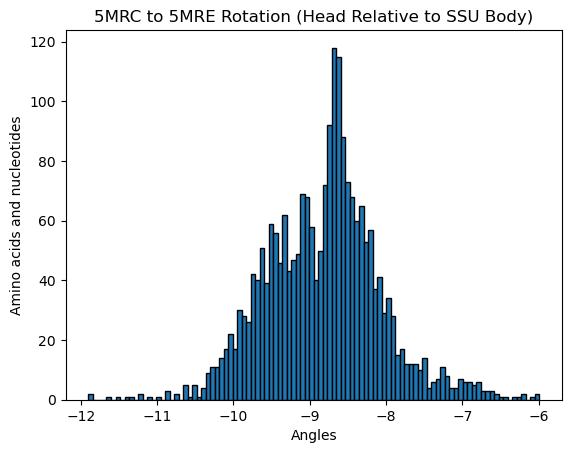

Mean angle: -8.824 degrees


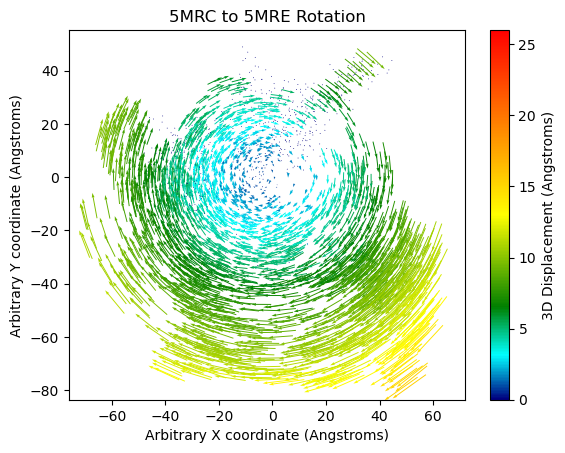

In [6]:
from scipy.optimize import minimize

################################
# Calculate angles of rotation #
################################

# Optimization function for choosing the center
def center_loss(center, projected_subset_1, projected_subset_2):
    piece_1 = center - projected_subset_1
    piece_2 = projected_subset_2 - projected_subset_1
    angles = np.arctan2(piece_1[:,1], piece_1[:,0]) - np.arctan2(piece_2[:,1], piece_2[:,0])
    angles = np.mod(angles + np.pi, 2 * np.pi) - np.pi
    return np.sum(np.abs(np.abs(angles) - np.pi/2))

# 3D distances
magnitudes = np.sqrt(np.sum(np.square(subset_1 - subset_2), axis=1))

# Choose best center
result = minimize(center_loss, [10, 180], # Initial guess for center
                  args=(projected_subset_1[magnitudes > 3], projected_subset_2[magnitudes > 3]),
                 method = 'Nelder-Mead',)

if result['success']:
    best_center = result['x']
else:
    raise ValueError("Failed to converge")
    
# Determine the angles
def best_angle(center, projected_subset_1, projected_subset_2):
    piece_1 = projected_subset_1 - center
    piece_2 = projected_subset_2 - center
    angles = np.arctan2(piece_2[:,1], piece_2[:,0]) - np.arctan2(piece_1[:,1], piece_1[:,0])
    angles = np.mod(angles + np.pi, 2 * np.pi) - np.pi
    return angles

# Histogram of angles
angles = best_angle(best_center, projected_subset_1[magnitudes > 3], projected_subset_2[magnitudes > 3]) * 180 / np.pi
plt.hist(angles, bins=100, edgecolor='black')
plt.title('5MRC to 5MRE Rotation (Head Relative to SSU Body)')
plt.xlabel("Angles")
plt.ylabel('Amino acids and nucleotides')
plt.savefig('outputs/5MRC_to_5MRE_head_X_Y_angles.pdf', format="pdf", dpi=3000, bbox_inches='tight')
plt.show()

print("Mean angle: " + str(np.round(np.mean(angles), 3)) + ' degrees')

# Center the projections
x = projected_subset_1[:, 0] - best_center[0]
y = projected_subset_1[:, 1] - best_center[1]
x2 = projected_subset_2[:, 0] - best_center[0]
y2 = projected_subset_2[:, 1] - best_center[1]

cmap = mcolor.LinearSegmentedColormap.from_list('colors',
                                                [(0, 'navy'),
                                              (0.12, 'cyan'),
                                              (0.25, 'green'),
                                              (0.5, 'yellow'),
                                              (1, 'red')], N=256)

# Create a vector plot
plt.quiver(x, y, x2-x, y2-y, magnitudes, angles='xy', scale_units='xy', scale=1, cmap=cmap)

plt.axis('equal')
plt.xlabel('Arbitrary X coordinate (Angstroms)')
plt.ylabel('Arbitrary Y coordinate (Angstroms)')
plt.title('5MRC to 5MRE Rotation')
plt.colorbar(label='3D Displacement (Angstroms)')
plt.clim(0,26)

plt.savefig('outputs/5MRC_to_5MRE_head_X_Y_rotation.pdf', format="pdf",  dpi=3000, bbox_inches='tight')
plt.show()

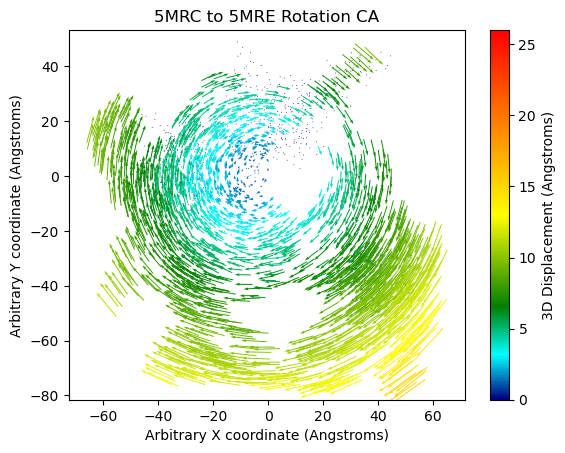

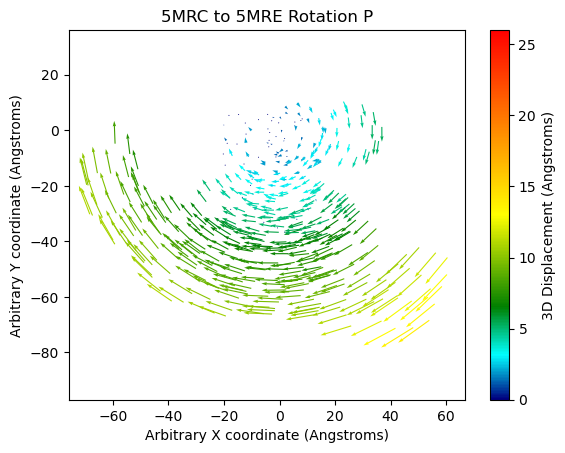

In [7]:
# Same as above but only with P and CA
def show_subset(atom_type):
    subset_1_tmp = subset_1[subset_1_df['AtomName'] == atom_type, :]
    subset_2_tmp = subset_2[subset_2_df['AtomName'] == atom_type, :]
    magnitudes_tmp = magnitudes[subset_2_df['AtomName'] == atom_type]
        
    normal_vector = svm.coef_[0]
    bias = svm.intercept_[0]

    projected_subset_1 = project_onto_plane(subset_1_tmp, normal_vector, bias)
    projected_subset_2 = project_onto_plane(subset_2_tmp, normal_vector, bias)
        
    x = projected_subset_1[:, 0] - best_center[0]
    y = projected_subset_1[:, 1] - best_center[1]
    x2 = projected_subset_2[:, 0] - best_center[0]
    y2 = projected_subset_2[:, 1] - best_center[1]
    
    
    cmap = mcolor.LinearSegmentedColormap.from_list('colors',
                                                    [(0, 'navy'),
                                                  (0.12, 'cyan'),
                                                  (0.25, 'green'),
                                                  (0.5, 'yellow'),
                                                  (1, 'red')], N=256)

    plt.quiver(x, y, x2-x, y2-y, magnitudes_tmp, angles='xy', scale_units='xy', scale=1, cmap=cmap)
    
    plt.axis('equal')
    plt.xlabel('Arbitrary X coordinate (Angstroms)')
    plt.ylabel('Arbitrary Y coordinate (Angstroms)')
    plt.title('5MRC to 5MRE Rotation ' + atom_type)
    plt.colorbar(label='3D Displacement (Angstroms)')
    plt.clim(0,26)

    plt.savefig('outputs/5MRC_to_5MRE_head_X_Y_rotation_' + atom_type + '.pdf', format="pdf", dpi=3000, bbox_inches='tight')
    plt.show()

atom_types = ['CA', 'P']

for atom_type in atom_types:
    show_subset(atom_type)